# CHAPTER 5.6

### Implementing a variational autoencoder

Variational Autoencoders (VAEs), They differ from the rest of the autoencoders in that, instead of learning an arbitrary function, they learn a probability distribution of the input images. We can then sample this distribution to produce new, unseen data points.A VAE is, in fact, a generative model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import *
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam

In [2]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [3]:
class VAE(object):
    def __init__(self,
                 original_dimension=784,
                 encoding_dimension=512,
                 latent_dimension=2):
        self.original_dimension = original_dimension
        self.encoding_dimension = encoding_dimension
        self.latent_dimension = latent_dimension

        self.z_log_var = None
        self.z_mean = None

        self.inputs = None
        self.outputs = None

        self.encoder = None
        self.decoder = None
        self.vae = None

    def build_vae(self):
        # Build encoder
        self.inputs = Input(shape=(self.original_dimension,))
        x = Dense(self.encoding_dimension)(self.inputs)
        x = ReLU()(x)
        self.z_mean = Dense(self.latent_dimension)(x)
        self.z_log_var = Dense(self.latent_dimension)(x)

        z = Lambda(sampling)([self.z_mean, self.z_log_var])

        self.encoder = Model(self.inputs,
                             [self.z_mean, self.z_log_var, z])

        # Build decoder
        latent_inputs = Input(shape=(self.latent_dimension,))
        x = Dense(self.encoding_dimension)(latent_inputs)
        x = ReLU()(x)
        self.outputs = Dense(self.original_dimension)(x)
        self.outputs = Activation('sigmoid')(self.outputs)
        self.decoder = Model(latent_inputs, self.outputs)

        # Build end-to-end VAE.
        self.outputs = self.encoder(self.inputs)[2]
        self.outputs = self.decoder(self.outputs)
        self.vae = Model(self.inputs, self.outputs)

    @tf.function
    def train(self,
              X_train,
              X_test,
              epochs=50,
              batch_size=64):
        reconstruction_loss = mse(self.inputs, self.outputs)
        reconstruction_loss *= self.original_dimension

        kl_loss = (1 + self.z_log_var -
                   K.square(self.z_mean) -
                   K.exp(self.z_log_var))
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5

        vae_loss = K.mean(reconstruction_loss + kl_loss)

        self.vae.add_loss(vae_loss)
        self.vae.compile(optimizer=Adam(lr=1e-3))
        self.vae.fit(X_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     validation_data=(X_test, None))

        return self.encoder, self.decoder, self.vae


In [4]:
def sampling(arguments):
    z_mean, z_log_var = arguments
    batch = K.shape(z_mean)[0]
    dimension = K.int_shape(z_mean)[1]

    epsilon = K.random_normal(shape=(batch, dimension))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
def generate_and_plot(decoder, grid_size=5):
    cell_size = 28

    figure_shape = (grid_size * cell_size,
                    grid_size * cell_size)
    figure = np.zeros(figure_shape)
    grid_x = np.linspace(-4, 4, grid_size)
    grid_y = np.linspace(-4, 4, grid_size)[::-1]

    for i, z_log_var in enumerate(grid_y):
        for j, z_mean in enumerate(grid_x):
            z_sample = np.array([[z_mean, z_log_var]])
            generated = decoder.predict(z_sample)[0]

            # Reshape as image.
            fashion_item = generated.reshape(cell_size,
                                             cell_size)

            # Assign to the corresponding cell in the grid.
            y_slice = slice(i * cell_size,
                            (i + 1) * cell_size)
            x_slice = slice(j * cell_size,
                            (j + 1) * cell_size)
            figure[y_slice, x_slice] = fashion_item

    plt.figure(figsize=(10, 10))
    start = cell_size // 2
    end = (grid_size - 2) * cell_size + start + 1
    pixel_range = np.arange(start, end, cell_size)

    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel('z_mean')
    plt.ylabel('z_log_var')
    plt.imshow(figure)
    plt.show()


In [6]:
(X_train, _), (X_test, _) = fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

In [7]:
vae = VAE(original_dimension=784,
          encoding_dimension=512,
          latent_dimension=2)

In [11]:
vae.build_vae()


In [12]:
vae

In [13]:
_, decoder_model, vae_model = vae.train(X_train, X_test,
                                        epochs=100)

C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
938/938 [==============================] - 22s 23ms/step - loss: 38.6455 - val_loss: 33.0558
Epoch 2/100
938/938 [==============================] - 20s 22ms/step - loss: 32.3695 - val_loss: 31.6834
Epoch 3/100
938/938 [==============================] - 20s 22ms/step - loss: 31.3882 - val_loss: 31.0832
Epoch 4/100
938/938 [==============================] - 20s 21ms/step - loss: 30.8212 - val_loss: 30.5032
Epoch 5/100
938/938 [==============================] - 19s 20ms/step - loss: 30.4068 - val_loss: 30.1876
Epoch 6/100
938/938 [==============================] - 19s 21ms/step - loss: 30.0556 - val_loss: 29.8586
Epoch 7/100
938/938 [==============================] - 20s 21ms/step - loss: 29.7409 - val_loss: 29.4807
Epoch 8/100
938/938 [==============================] - 19s 20ms/step - loss: 29.3761 - val_loss: 29.1502
Epoch 9/100
938/938 [==============================] - 19s 21ms/step - loss: 29.1368 - val_loss: 29.2042
Epoch 10/100
938/938 [==============================] -

In [30]:
vae_model.save('vae_fit.h5')

In [31]:
decoder_model.save('decoder_model_fit.h5')

In [26]:
cell_size = 28
grid_size=5
grid_x = np.linspace(-4, 4, grid_size)
print(grid_x)
grid_y = np.linspace(-4, 4, grid_size)[::-1]
print(grid_y)
plt.figure(figsize=(10, 10))
start = cell_size // 2
print(start)
end = (grid_size - 2) * cell_size + start + 1
print(end)
pixel_range = np.arange(start, end, cell_size)
print(pixel_range)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)

[-4. -2.  0.  2.  4.]
[ 4.  2.  0. -2. -4.]
14
99
[14 42 70 98]


<Figure size 720x720 with 0 Axes>

In [ ]:
generate_and_plot(decoder_model, grid_size=7)

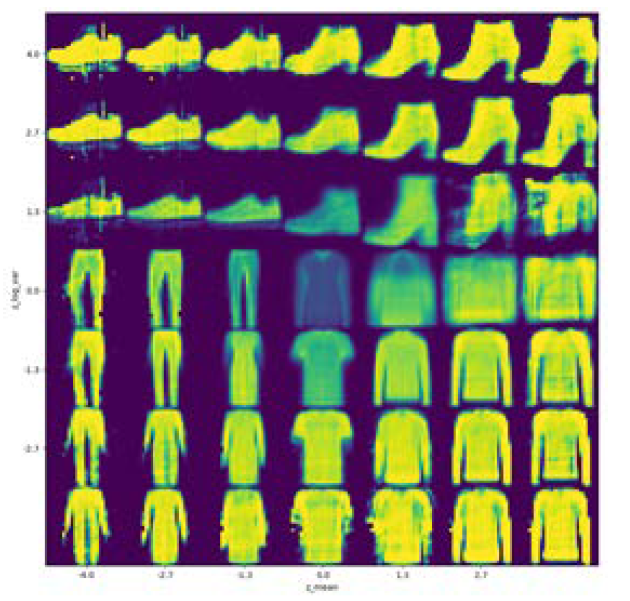